In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import seaborn as sns
from scipy import stats
import cv2
gait_dir = '/Users/iwoods/Documents/GitHub/gait/'
this_dir = os.getcwd()
os.chdir(gait_dir)
import gaitFunctions
import combineClips
import plotClip
os.chdir(this_dir)
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#b45eff' # lavender
first_pair_color_alt = '#661f99' # purple
second_pair_color = '#006f2a' # green
second_pair_color_alt = '#02db55' # light green
third_pair_color = '#ffd500' # yellow
third_pair_color_alt = '#fa9805' # orange
rear_leg_color = '#00b6eb'# light blue
rear_leg_color_alt = '#0010eb' # dark blue

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Option 1: Select the folders to include in the analysis ... (or see below)

In [4]:
# navigate to directory that contains the data
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_disulfiram/'
os.chdir(main_dir)
# list directories within this directory
dirs = []
for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        folder = os.path.join(dirname, subdirname).split('/')[1]
        if folder not in dirs:
            dirs.append(folder)
dirs = np.sort(np.unique(np.array(dirs)))
dirs = [x for x in dirs if 'disulfiram' in x.lower()] # change to babies or adults or ramazzottius or disulfiram
folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) 


Choose from this list (separate by commas if multiple choices): 
1: Disulfiram 12Jan24 Inverted
2: Disulfiram 13Dec23 Inverted
3: Disulfiram 16Dec22 Inverted
4: Disulfiram 8Dec22 Inverted
5: comparing disulfiram
6: xDisulfiram 21Nov22 dissectingscope
7: zDisulfiram 16Nov23 TTclass StudentVids
8: zDisulfiram 21April23 weakdrug
9: select ALL

Which number(s) do you want? 1,2,3,4
You chose: Disulfiram 12Jan24 Inverted and Disulfiram 13Dec23 Inverted and Disulfiram 16Dec22 Inverted and Disulfiram 8Dec22 Inverted


# Option 2: Manually select the folders

In [ ]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_wild/ramazzottius_14Sep23',
                       base_dir + 'videos_wild/ramazzottius_21Sep23',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted'
]

# Load the data in the selected folders

In [5]:
### in each folder, look for a 'combined' excel file and load (or append) it to a dataframe
# if there is no 'combined' excel file, run combineClips and then load the file
os.chdir(main_dir)

path_summaries_df = pd.DataFrame()
step_timing_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def appendDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    combined_files = sorted(glob.glob('*combined*xlsx'))
    if len(combined_files) == 0:
        print('Combining .xlsx files in ' + folder)
        pdf, stcdf, sdf, gdf, gssdf = combineClips.main(True)
    elif len(combined_files) == 1:
        excel_file = combined_files[0]
        print('Found ' + combined_files[0])
        
        # read in data from this excel file
        pdf = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
        stdf = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
        sdf = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
        gdf = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
        gssdf = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
        
        # append to existing dataframe
        path_summaries_df = appendDF(path_summaries_df, pdf)
        step_timing_df = appendDF(step_timing_df, stdf)
        step_summaries_df = appendDF(step_summaries_df, sdf)
        gait_summaries_df = appendDF(gait_summaries_df, gdf)
        gait_styles_speeds_df = appendDF(gait_styles_speeds_df, gssdf)
    else:
        print('Too many "combined" files in ' + folder)
    os.chdir(main_dir)
path_summaries_df.head(5)

Found Disulfiram 12Jan24 Inverted_combined.xlsx
Found Disulfiram 13Dec23 Inverted_combined.xlsx
Found Disulfiram 16Dec22 Inverted_combined.xlsx
Found Disulfiram 8Dec22 Inverted_combined.xlsx


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec,Speed (mm/s),Speed (body lengths / s)
0,iw_12jan_tardigrade01_control,control,tardigrade01,12jan,956.03,0.012985,0.238598,0.073853,0.309530,99.5535,...,0.188211,2377.436000,23.880989,15.608393,13,0.130583,8,0.080359,NaN,NaN
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,12jan,956.03,0.011568,0.211995,0.075648,0.356837,167.7272,...,0.149659,6954.287733,41.461896,22.670600,61,0.363686,44,0.262331,NaN,NaN
2,iw_12jan_tardigrade02_control,control,tardigrade02,12jan,956.03,0.014216,0.247831,0.077100,0.311102,115.2875,...,0.171954,2330.605200,20.215593,16.363241,18,0.156131,9,0.078066,NaN,NaN
3,iw_12jan_tardigrade02_disulfiram,disulfiram,tardigrade02,12jan,956.03,0.014620,0.250047,0.079605,0.318362,107.3940,...,0.158144,2297.907267,21.396980,15.860098,22,0.204853,7,0.065181,NaN,NaN
4,iw_12jan_tardigrade03_control,control,tardigrade03,12jan,956.03,0.011513,0.225085,0.068042,0.302294,110.8947,...,0.233415,1536.464000,13.855162,10.619561,4,0.036070,4,0.036070,NaN,NaN


In [6]:
# see how many things are in the 'treatment' column ... may need to fix.
print(np.unique(path_summaries_df.treatment.values))

['control' 'disulfiram']


# Path Tracking

In [7]:
print(path_summaries_df.columns)
to_compare_path =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
    #'Distance traveled (mm)', 
    'Percentage of time cruising',
#     'Speed (mm/sec)',
#     'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
    'Stops / sec',
#     'Number of turns', 
    'Turns / sec'
]
print(len(to_compare_path))

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'Speed (mm/s)',
       'Speed (body lengths / s)'],
      dtype='object')
7



Body Size (mm^2) 0.01928373989071681


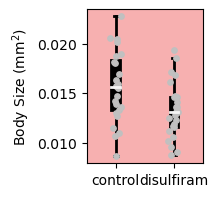

In [8]:
def compBoxPlot(ax,df,col,numcomps): 

    groupnames = sorted(np.unique(df.treatment.values))
    
    # rearrange groupnames so 'control' is first
    if 'control' in groupnames:
#         print('Rearranging group so control is first!')
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 15 # marker size
    ji = 0.05 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # do some stats?
    if len(data_to_plot) == 2:
        pval = gaitFunctions.statsFromBoxData(data_to_plot, 'kw', False)[0]
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    if pval < 0.05/numcomps:
        fc = '#f7b0b0' # pinkish
        print(col,pval)
    elif pval < 0.05/(numcomps/2):
        fc = '#fcca74' # orange-ish
        print(col,pval)
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

f,ax = plt.subplots(1,1,figsize=(1.5,2))
ax = compBoxPlot(ax,path_summaries_df,'Body Size (mm^2)',1)
plt.show()



Body Length (mm) 0.0035003138573522097

Body Width/Length Ratio 0.01313823827109361

Percentage of time cruising 6.183963137912378e-06

Speed (body lengths / sec cruising) 0.0006480327716033209

Bearing change (deg) / sec cruising 0.00807148742526795

Stops / sec 0.00397582506971522



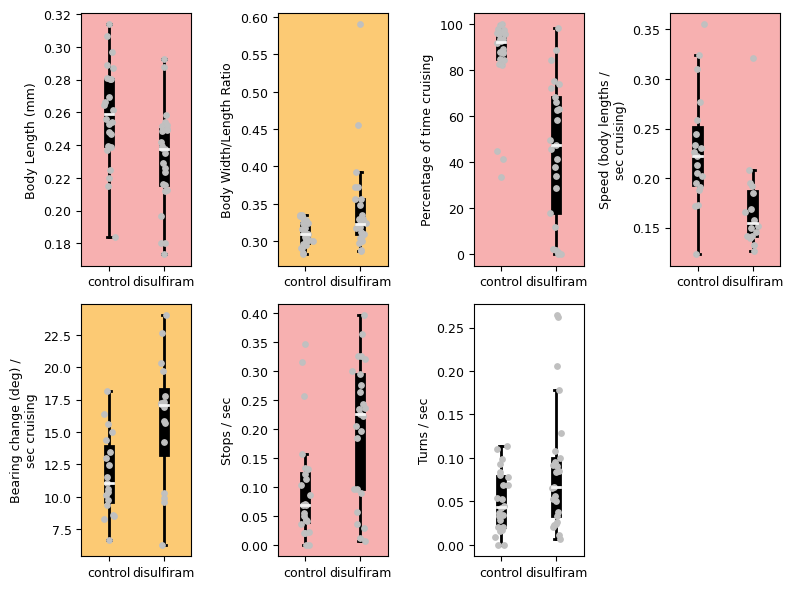

In [9]:
rows,cols = [2,4]
f,axes = plt.subplots(rows,cols,figsize = (8,6))
axes_list = axes.reshape(1,len(to_compare_path)+1)[0]
for i, col in enumerate(to_compare_path):
    axes_list[i] = compBoxPlot(axes_list[i], path_summaries_df, col, len(to_compare_path))
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes_list[-1].set_axis_off()
plt.tight_layout()
plt.show()

# Step kinematics

In [10]:
# print(step_summaries_df.columns)
to_compare_steps = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
#     'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)',
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
    'Metachronal lag Left-Right Ratio',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(to_compare_steps))

10



Stance duration (lateral legs) 0.0011431765973566456

Swing duration (lateral legs) 2.7257155710234262e-06



Swing duration (rear legs) 1.9882083060430692e-05







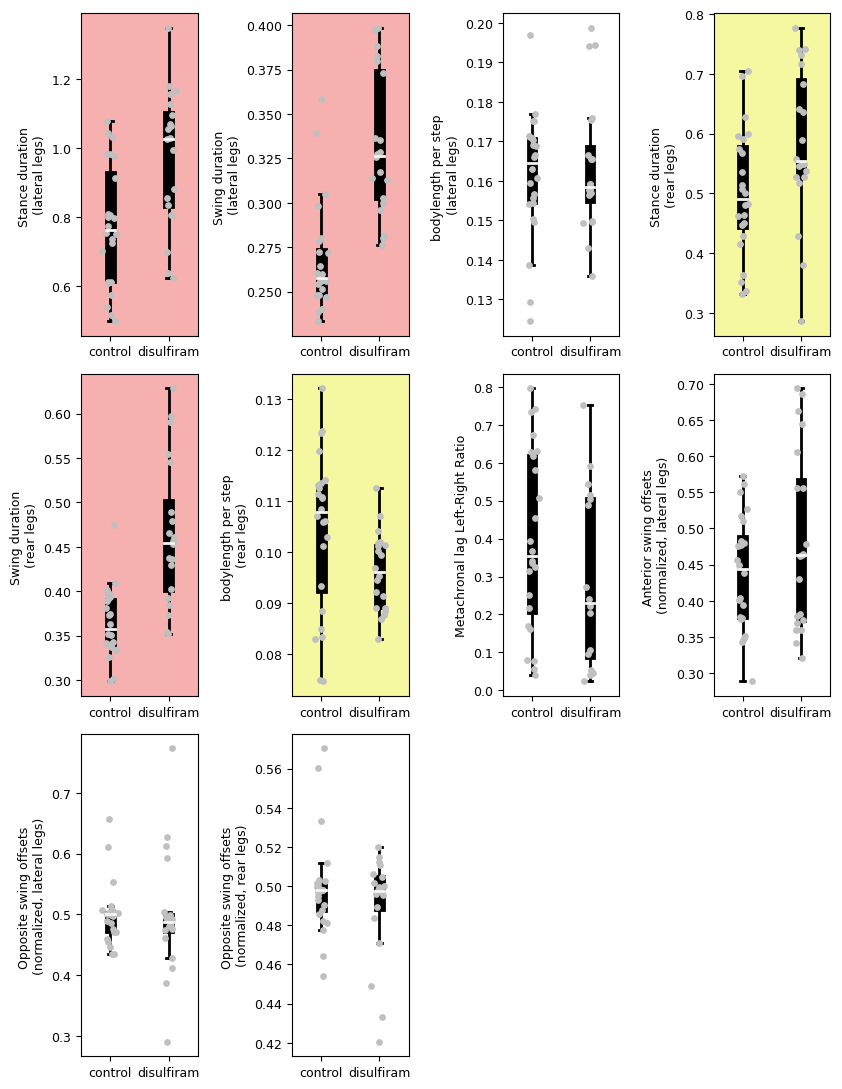

In [11]:
rows,cols = [3,4]
f,axes = plt.subplots(rows,cols,figsize = (8.5,11))
axes_list = axes.reshape(1,len(to_compare_steps)+2)[0]
for i, col in enumerate(to_compare_steps):
    axes_list[i] = compBoxPlot(axes_list[i], step_summaries_df, col, len(to_compare_steps))
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes_list[10].set_axis_off()
axes_list[11].set_axis_off()
plt.tight_layout()
plt.show()

# Speed and swing time
For Disulfiram (or comparison where one group is slower),
<br> the swing duration (and stance duration) could be longer 
<br> just because the speed is slower.
<br>To test, would need to normalize for speed.
<br> One way = plot speed vs. avg swing or stance length ... still a diff at same speeds?

# Gait styles

In [12]:
# print(gait_summaries_df.columns)
to_compare_gait = [
    '% stand (lateral legs)',
    '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
    '% stand (rear legs)', 
    '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
]
print(len(to_compare_gait))

9


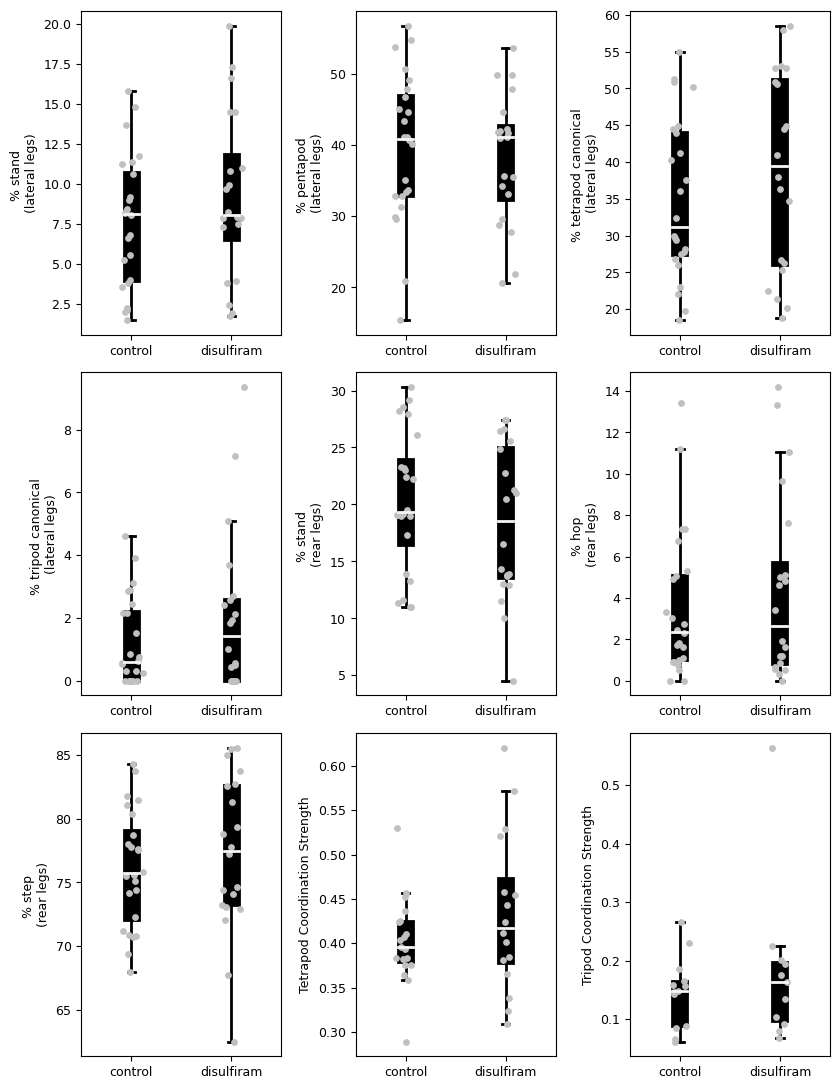

In [13]:
rows,cols = [3,3]
f,axes = plt.subplots(rows,cols,figsize = (8.5,11))
axes_list = axes.reshape(1,len(to_compare_gait))[0]
for i, col in enumerate(to_compare_gait):
    axes_list[i] = compBoxPlot(axes_list[i], gait_summaries_df, col, len(to_compare_gait))
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()